# Topic - Sentiment Distribution and Extremes Analysis

This notebook accomplishes the following tasks:
1. perform LDA theme modeling on tweets
2. Analyze the sentiment distribution under each topic
3. Identify extreme sentiment topics
4. Visualize the analysis results

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
warnings.filterwarnings('ignore')


## 2. LDA theme modeling

In [2]:
import pandas as pd

df = pd.read_csv("../2_data/tweet_level_sentiment.csv")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# add financial-specific stop words
financial_stop_words = {'stock', 'market', 'price', 'trading', 'trade', 'investor', 'investment', 
                       'nvda', 'nvidia', 'share', 'shares', 'buy', 'sell', 'hold', 'bullish', 
                       'bearish', 'chart', 'technical', 'analysis', 'fundamental', 'earnings', 
                       'quarter', 'report', 'financial', 'company', 'firm', 'business'}
stop_words.update(financial_stop_words)

def preprocess_text(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

df['processed_text'] = df['Processed_Tweet'].apply(preprocess_text)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['processed_text'])

n_topics = 8  
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method='online',
    random_state=42,
    batch_size=128,
    verbose=0
)

topic_distribution = lda.fit_transform(X)
df['topic'] = topic_distribution.argmax(axis=1)

feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

print("Keywords for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


    topic_sentiment_stats = df.groupby('topic')['sentiment_score'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: (x > 0.5).mean(),   # high positive sentiment ratio
    lambda x: (x < -0.5).mean()   # high negative sentiment ratio
]).round(4)
topic_sentiment_stats.columns = [
    'number of tweets', 'Avg Sentiment', 'standard deviation', 'Min', 'Max',
    'High positive ratio', 'High negative ratio'
]
print(topic_sentiment_stats)

df.to_csv("../2_data/tweets_with_LDAtopics.csv", index=False)


[nltk_data] Downloading package punkt to /Users/q/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/q/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Keywords for each topic:
Topic 1: compani, amp, chip, arm, lower, said, game, sinc, better, like
Topic 2: today, day, tomorrow, like, close, week, look, let, bull, green
Topic 3: time, short, long, dip, high, year, got, make, fuck, like
Topic 4: tsla, good, great, look, strong, gap, support, start, stay, alway
Topic 5: spi, aapl, amd, qqq, bought, amzn, msft, posit, lol, split
Topic 6: earn, rocket, watch, hour, new, hope, bad, news, everi, data
Topic 7: amd, intc, anoth, load, tri, continu, rip, work, semi, miss
Topic 8: come, big, money, drop, want, wait, nice, soon, run, bounc
       number of tweets  Avg Sentiment  standard deviation  Min  Max  \
topic                                                                  
0                 35352         0.0564              0.5026 -1.0  1.0   
1                 58716         0.0862              0.6124 -1.0  1.0   
2                 34186        -0.0253              0.6940 -1.0  1.0   
3                 24568         0.1895              0


## 3. Theme-sentiment distribution analysis

       number of tweets  Avg Sentiment  standard deviation  Min  Max  \
topic                                                                  
0                 42442         0.0281              0.3536 -1.0  1.0   
1                 40138         0.0518              0.4415 -1.0  1.0   
2                 21729         0.0192              0.4196 -1.0  1.0   
3                 40388         0.0324              0.4951 -1.0  1.0   
4                 37760        -0.0248              0.4495 -1.0  1.0   
5                 34921         0.0265              0.4124 -1.0  1.0   
6                 23186        -0.0336              0.4152 -1.0  1.0   
7                 26082         0.1690              0.4893 -1.0  1.0   

       High positive ratio  High negative ratio  
topic                                            
0                   0.0770               0.0489  
1                   0.1247               0.0729  
2                   0.0978               0.0786  
3                   0.1393   

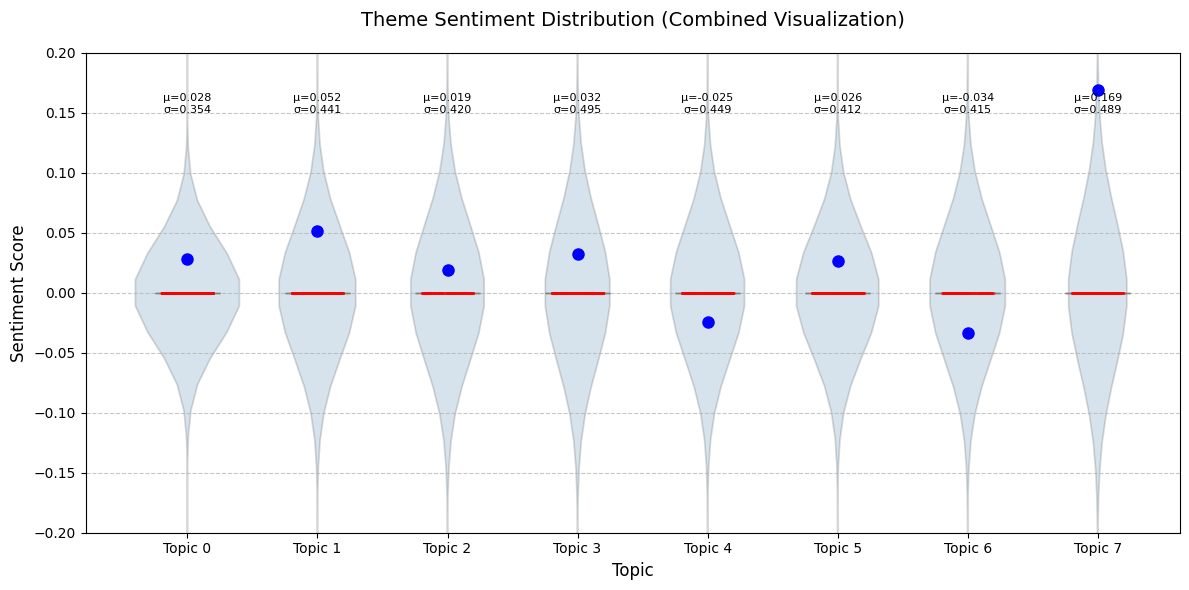

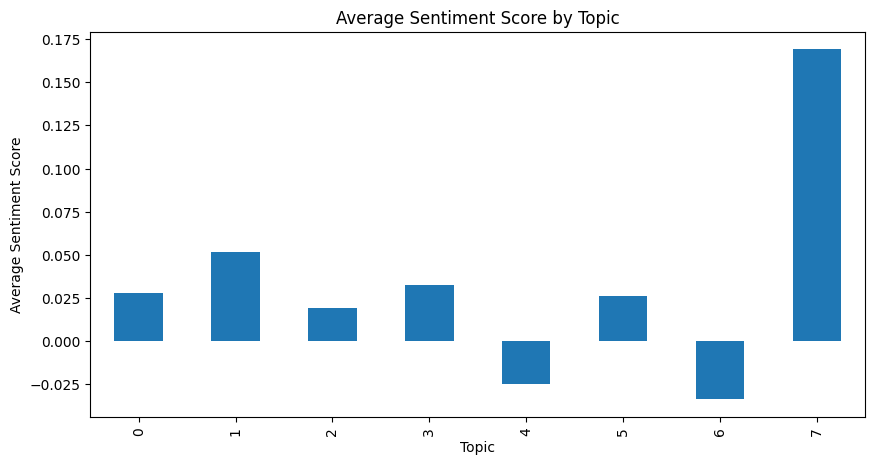

In [3]:
import pandas as pd

df = pd.read_csv("../2_data/tweets_with_topics.csv")

topic_sentiment_stats = df.groupby('topic')['sentiment_score'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: (x > 0.5).mean(),   # high positive sentiment ratio
    lambda x: (x < -0.5).mean()   # high negative sentiment ratio
]).round(4)

topic_sentiment_stats.columns = [
    'number of tweets', 'Avg Sentiment', 'standard deviation', 'Min', 'Max',
    'High positive ratio', 'High negative ratio'
]

print(topic_sentiment_stats)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# visualization
# 1. Box plot (no outliers shown)
ax = sns.boxplot(x='topic', y='sentiment_score', data=df,
                width=0.5,
                showfliers=False,  
                color='lightgrey')

# 2. Adding a jitter scatterplot to a box plot
sns.stripplot(x='topic', y='sentiment_score', 
             data=df.sample(n=5000, random_state=42),  # 采样5000个点
             size=2, alpha=0.3, 
             jitter=0.2,
             color='red')

# 3. add violin plot
sns.violinplot(x='topic', y='sentiment_score', data=df,
               alpha=0.2,  
               inner=None)  # do not show inner boxplot

# Set the display range to focus on the main distribution area
plt.ylim(-0.2, 0.2)

# add mean points
means = df.groupby('topic')['sentiment_score'].mean()
plt.plot(range(len(means)), means, 'o', color='blue', markersize=8, label='Mean')

plt.title('Theme Sentiment Distribution (Combined Visualization)', size=14, pad=20)
plt.xlabel('Topic', size=12)
plt.ylabel('Sentiment Score', size=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adding a Theme Tag
plt.xticks(range(8), [f'Topic {i}' for i in range(8)])

# Adding Statistical Information Labeling
for i, mean in enumerate(means):
    std = df[df['topic'] == i]['sentiment_score'].std()
    plt.text(i, 0.15, f'μ={mean:.3f}\nσ={std:.3f}', 
             horizontalalignment='center',
             size=8)

plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 5))
topic_sentiment_stats['Avg Sentiment'].plot(kind='bar')
plt.title('Average Sentiment Score by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

topic_sentiment_stats.to_csv("../2_data/LDAtopic_sentiment_stats.csv")



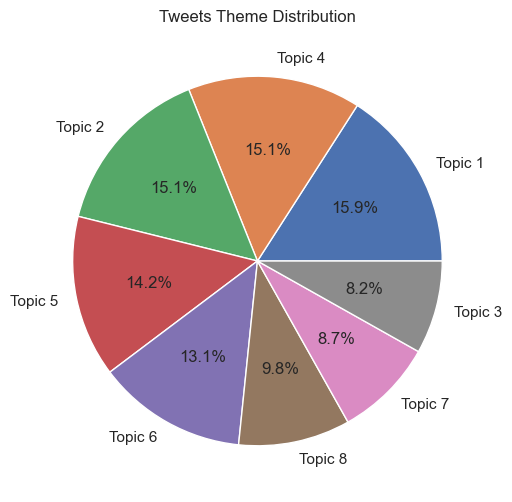

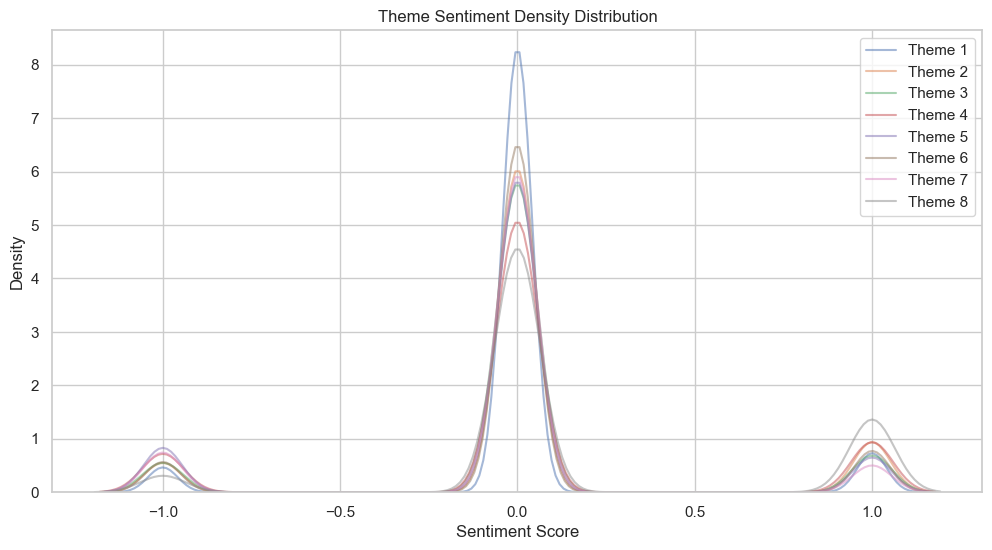

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_palette("husl")



sns.set_theme(style="whitegrid")  

# 1. Thematic Distribution Pie Chart
plt.figure(figsize=(12, 6))
topic_counts = df['topic'].value_counts()
plt.pie(topic_counts, labels=[f'Topic {i+1}' for i in topic_counts.index], autopct='%1.1f%%')
plt.title('Tweets Theme Distribution')
plt.show()

# 2. Theme Sentiment Density Plot
plt.figure(figsize=(12, 6))
n_topics = df['topic'].nunique()
for topic in range(n_topics):
    sns.kdeplot(data=df[df['topic'] == topic]['sentiment_score'], 
                label=f'Theme {topic+1}', alpha=0.5)
plt.title('Theme Sentiment Density Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

## 5. Extreme emotion topic analysis

In [5]:
print(df.columns)

Index(['Date', 'Processed_Tweet', 'sentiment_score', 'sentiment_label',
       'category', 'processed_text', 'topic'],
      dtype='object')


In [6]:
# Find the most extreme topic
most_positive_topic = topic_sentiment_stats['Avg Sentiment'].idxmax()
most_negative_topic = topic_sentiment_stats['Avg Sentiment'].idxmin()

print(f"Most positive theme (Theme {most_positive_topic + 1}):")
print(f"Average sentiment score: {topic_sentiment_stats.loc[most_positive_topic, 'Avg Sentiment']:.4f}")
print(f"High positive sentiment ratio: {topic_sentiment_stats.loc[most_positive_topic, 'High positive ratio']:.2%}")
print("\nExample tweets from this theme:")
print(df[df['topic'] == most_positive_topic]['Processed_Tweet'].head())

print(f"\nMost negative theme (Theme {most_negative_topic + 1}):")
print(f"Average sentiment score: {topic_sentiment_stats.loc[most_negative_topic, 'Avg Sentiment']:.4f}")
print(f"High negative sentiment ratio: {topic_sentiment_stats.loc[most_negative_topic, 'High negative ratio']:.2%}")
print("\nExample tweets from this theme:")
print(df[df['topic'] == most_negative_topic]['Processed_Tweet'].head())

Most positive theme (Theme 8):
Average sentiment score: 0.1690
High positive sentiment ratio: 21.85%

Example tweets from this theme:
7                  amzn sq nvda decemb stock mkt glitch
9     kristit sinc june ipo much better amzn nvda ti...
23    nvda reentri abl afford hous stock market rece...
24    idrawlin im still stick market cap floor nvda ...
28    thank spi dump move anyth possibl market look ...
Name: Processed_Tweet, dtype: object

Most negative theme (Theme 7):
Average sentiment score: -0.0336
High negative sentiment ratio: 10.36%

Example tweets from this theme:
20                nvda larg unusu print bullish bearish
22    nvda everyon scare short bearish let rug pull ...
26    aapl fb nvda googl nflx energi time spend stoc...
33                                   nvda heavi bullish
65    nvda cramer said stop trade go long nvda game ...
Name: Processed_Tweet, dtype: object


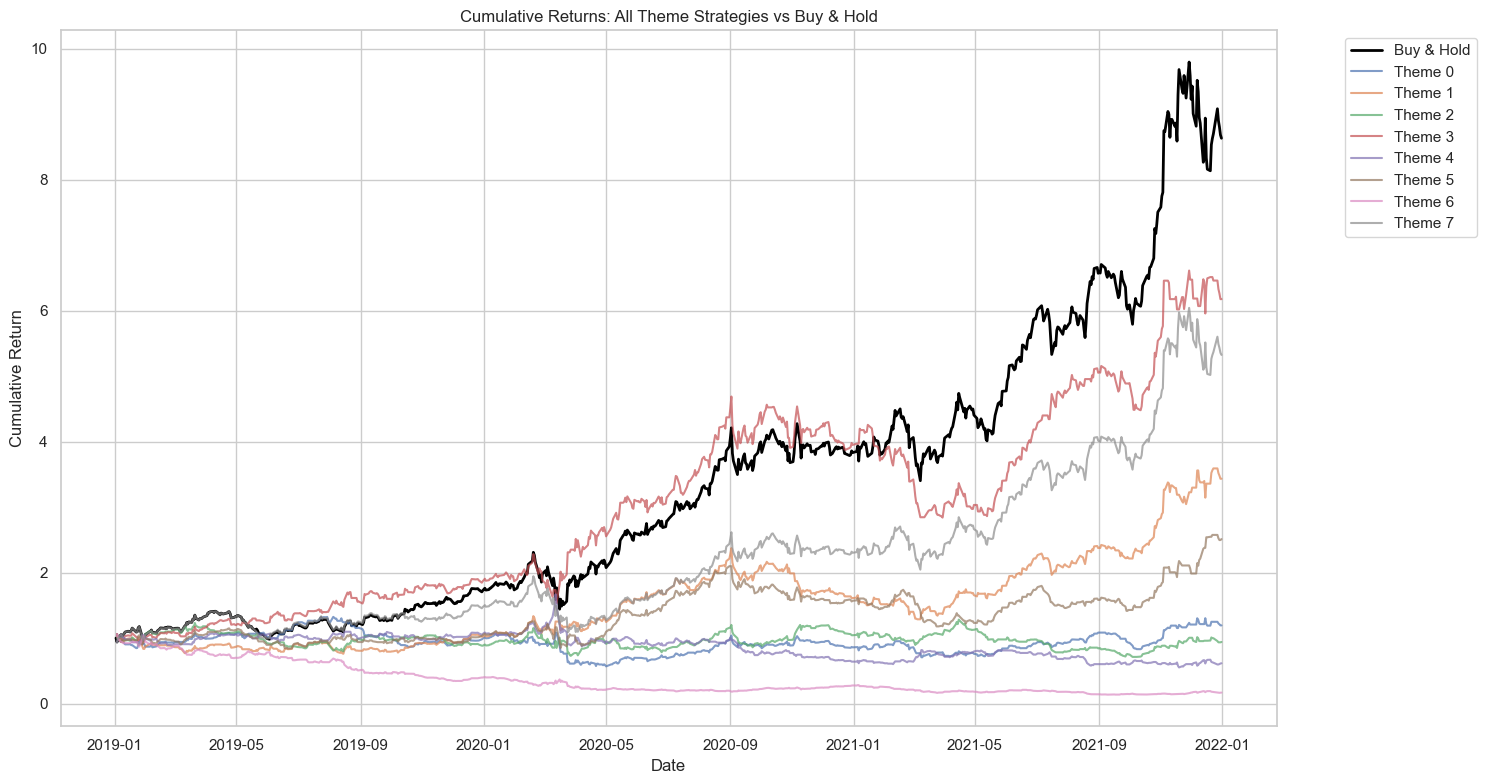


Final Returns by Thematic Strategy:
Theme 0: 19.37%
Theme 1: 243.43%
Theme 2: -5.95%
Theme 3: 517.83%
Theme 4: -38.50%
Theme 5: 151.23%
Theme 6: -83.27%
Theme 7: 432.65%
Buy & Hold: 763.63%


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. read
df['Date'] = pd.to_datetime(df['Date'])
daily_theme_sentiment = df.groupby(['Date', 'topic'])['sentiment_score'].mean().unstack()

# 2. get price data
price_df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv')
price_df['Date'] = pd.to_datetime(price_df['index'])
price_df = price_df.set_index('Date')

# 3. calculate daily returns
plt.figure(figsize=(15, 8))

# First draw the benefits of buy & hold
returns = price_df['nvda_close'].pct_change().fillna(0)
cum_returns = (1 + returns).cumprod()
plt.plot(cum_returns.index, cum_returns, label='Buy & Hold', color='black', linewidth=2)

# Calculate strategy returns for each theme
for theme in range(8):  
    # signal generation
    signal = daily_theme_sentiment[theme].rolling(3, min_periods=1).mean()
    position = (signal > 0.02).astype(int) - (signal < -0.02).astype(int)
    
    # data alignment
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # calculate strategy returns
    strategy_returns = strategy_data['position'].shift(1) * returns
    cum_strategy_returns = (1 + strategy_returns).cumprod()
    
    # plot
    plt.plot(cum_strategy_returns.index, cum_strategy_returns, label=f'Theme {theme}', alpha=0.7)

plt.title('Cumulative Returns: All Theme Strategies vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# print the final returns of each strategy
print("\nFinal Returns by Thematic Strategy:")
for theme in range(8):
    signal = daily_theme_sentiment[theme].rolling(3, min_periods=1).mean()
    position = (signal > 0.02).astype(int) - (signal < -0.02).astype(int)
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )
    strategy_returns = strategy_data['position'].shift(1) * returns
    final_return = (1 + strategy_returns).prod() - 1
    print(f"Theme {theme}: {final_return:.2%}")
print(f"Buy & Hold: {cum_returns[-1]-1:.2%}")

In [8]:
# Print top 50 keywords for topics 1, 3, and 7
topics_to_print = [0, 2, 6]  # Adjusted for zero-based indexing (Topic 1 -> 0, Topic 3 -> 2, Topic 7 -> 6)

for topic_idx in topics_to_print:
    top_words = [feature_names[i] for i in lda.components_[topic_idx].argsort()[:-51:-1]]  # Top 50 keywords
    print(f"Top 50 keywords for Topic {topic_idx + 1}:")
    print(', '.join(top_words))
    print()

Top 50 keywords for Topic 1:
compani, amp, chip, arm, lower, said, game, sinc, better, like, current, use, ill, care, man, make, invest, metavers, averag, gpu, china, valu, someon, news, card, technolog, bank, solid, doubl, plu, dead, question, shortag, margin, earlier, mani, definit, chang, old, covid, upgrad, understand, becom, send, industri, march, complet, june, approv, purchas

Top 50 keywords for Topic 3:
time, short, long, dip, high, year, got, make, fuck, like, gon, earn, level, term, shit, profit, love, best, bear, realli, feel, week, gain, sure, fed, think, rate, mayb, turn, pullback, analyst, someth, dollar, buyer, right, sold, sale, eye, trader, pick, incom, intel, kill, higher, congrat, sweep, amaz, crazi, matter, wrong

Top 50 keywords for Topic 7:
amd, intc, anoth, load, tri, continu, rip, work, semi, miss, fall, pull, tsm, add, billion, googl, lose, print, weak, everyth, live, announc, qcom, swing, worth, help, didnt, talk, demand, pretti, inflat, surpris, bring, russi

In [10]:
import pandas as pd

# 读取数据
df = pd.read_csv("../2_data/tweets_with_LDAtopics.csv")

# 确保日期列为 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 计算每个主题的统计数据
topic_stats = df.groupby(['Date', 'topic'])['sentiment_score'].agg(
    avg_sentiment_score='mean',
    tweet_count='count',
    sentiment_std='std'
).reset_index()

# 仅处理主题 1、3 和 7
topics_to_save = [1, 3, 7]  # 注意：主题编号是从 0 开始的

for topic in topics_to_save:
    topic_data = topic_stats[topic_stats['topic'] == topic][['Date', 'avg_sentiment_score', 'tweet_count', 'sentiment_std']]
    topic_data.rename(columns={'Date': 'date'}, inplace=True)
    topic_data.to_csv(f"../2_data/topic_{topic}_LDA_sentiment_stats.csv", index=False)
    print(f"Saved topic {topic} data to ../2_data/topic_{topic}_LDA_sentiment_stats.csv")

Saved topic 1 data to ../2_data/topic_1_LDA_sentiment_stats.csv
Saved topic 3 data to ../2_data/topic_3_LDA_sentiment_stats.csv
Saved topic 7 data to ../2_data/topic_7_LDA_sentiment_stats.csv
